# Assignment 2: Stochastic and Spatial Models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gillespie as gil
from scipy.integrate import solve_ivp
import random

### Gillespie’s Direct Algorithm and Stochastic Hallmarks

First, let's fix a random seed to ensure reproducibility.

In [2]:
seed_value = 20
np.random.seed(seed_value)
random.seed(seed_value)

We need to implement the Gillespie's Direct Algorithm to simulate the stochastic model. 

In [3]:
def gillespie(initial_conditions, propensities, stoichiometry, t_max):
    s, i, r = initial_conditions
    time = 0
    time_values = [time]
    results = [[s, i, r]]

    # Run the simulation
    while time < t_max and i > 0:  # Stop if no infected individuals or max time reached
        # Calculate the rates for each event
        rates = [f(s, i, r) for f in propensities]
        total_rate = sum(rates)

        if total_rate == 0:
            break

        # Time until the next event
        # time_step = - (1/total_rate) * log(random number)
        time_step = np.random.exponential(1 / total_rate)
        
        # Choose which event occurs
        event = np.random.choice(len(rates), p=[rate / total_rate for rate in rates])
        
        # Uptade the time
        time += time_step
        # Update the population based on the stoichiometry of the selected event
        s += stoichiometry[event][0]
        i += stoichiometry[event][1]
        r += stoichiometry[event][2]

        # Store the new values
        time_values.append(time)
        results.append([s, i, r])

    return time_values, results

For the Gillespie's algorithm, we need to define the events and their rates from the SIR model. There are a total of 6 events: birth into the susceptible pool, infection of a susceptible individual, recovery of an infected individual, death of a susceptible individual, death of an infected individual, and death of a recovered individual. 

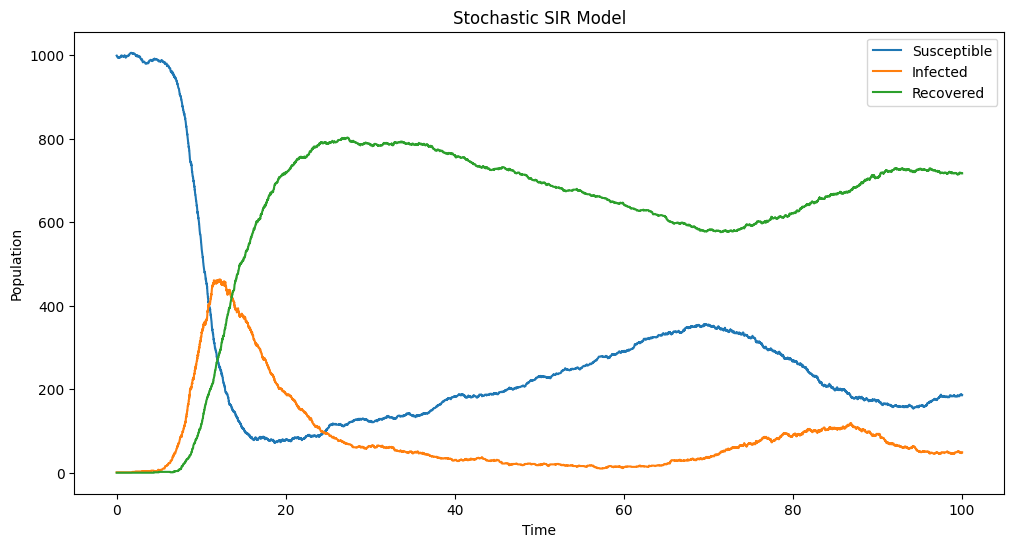

In [4]:
# Defining the parameters
beta = 1  # infection rate
gamma = 1/5  # recovery rate
mu = 1/60  # birth and death rate
N = 1000  # total population

# Initial conditions
S0 = 999
I0 = 1
R0 = 0
t = 100 # duration

initial_conditions = [S0, I0, R0]

propensities = [lambda s, i, r: beta * s * i / N, # infection 
                        lambda s, i, r: gamma * i,   # recovery
                        lambda s, i, r: mu*N  ,   # birth
                        lambda s, i, r: mu * s,  # death from susceptible group
                        lambda s, i, r: mu * i ,  # death from infected group
                        lambda s, i, r: mu * r]  # death from recovered group

stoichiometry = [[-1, 1, 0],  # infection; Population change: S-1, I+1, R+0
                            [0, -1, 1],  # Recovery; Population change: S+0, I-1, R+1
                            [1, 0, 0],   # Birth: Population change: S+1, I+0, R+0 
                            [-1, 0, 0],  # Death in S; Population change: S-1, I+0, R+0
                            [0, -1, 0],  # Death in I; Population change: S+0, I-1, R+0
                            [0, 0, -1]] # Death in R; Population change: S+0, I+0, R-1

# Running the simulation
time, result = gillespie(initial_conditions, propensities, stoichiometry, t)
S, I, R = zip(*result)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(time, S, label='Susceptible')
plt.plot(time, I, label='Infected')
plt.plot(time, R, label='Recovered')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Stochastic SIR Model')
plt.legend()
plt.show()

Comparing with a deterministic ODE model:

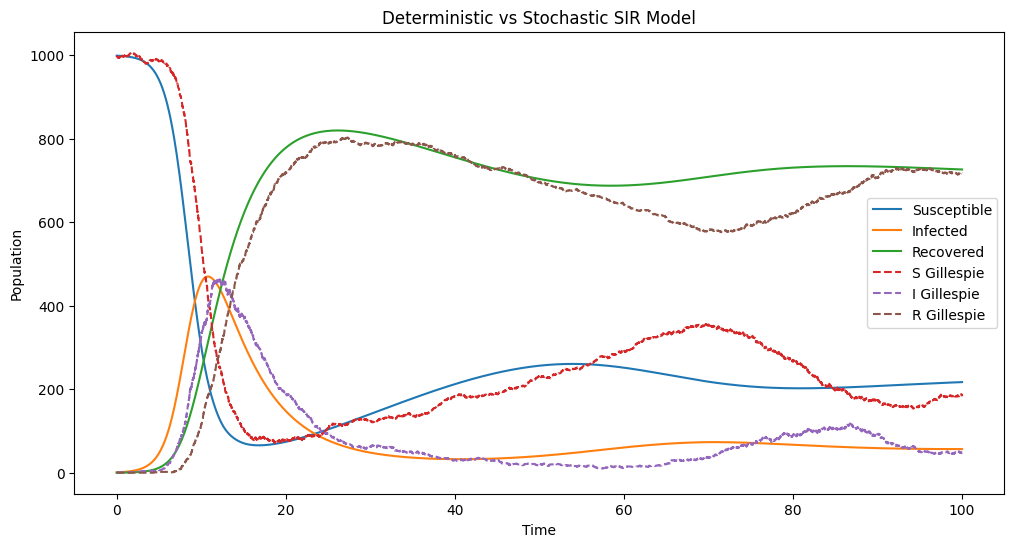

In [5]:
def sir_model(t, y, beta, gamma, mu):
    S, I, R = y
    dSdt = mu*N  - beta * S * I/N  - mu * S
    dIdt = beta * S * I/N - gamma * I - mu * I
    dRdt = gamma * I- mu * R
    return [dSdt, dIdt, dRdt]

sol = solve_ivp(sir_model, [0, t], initial_conditions, args=(beta, gamma, mu), t_eval=np.linspace(0, t, 1000))
S_d, I_d, R_d = sol.y

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(sol.t, S_d, label='Susceptible')
plt.plot(sol.t, I_d , label='Infected')
plt.plot(sol.t, R_d, label='Recovered')

plt.plot(time, S, linestyle = "--", label='S Gillespie')
plt.plot(time, I, linestyle = "--", label='I Gillespie')
plt.plot(time, R, linestyle = "--", label='R Gillespie')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Deterministic vs Stochastic SIR Model')
plt.legend()
plt.show()

### NOISE PART MISSING!!!

In [6]:

def multiple_runs(params, num_runs, t_max):
    beta, gamma, mu = params
    # Initializing the lists to store the results
    S_mean = []
    I_mean = []
    S_var = []
    I_var = []
    S_I_cov = []

    for i in range(num_runs):
        # Running the simulation
        time, result = gillespie(initial_conditions, propensities, stoichiometry, t_max)
        S, I, R = zip(*result)
        # Storing the mean and variance of S and I
        S_mean.append(np.mean(S))
        I_mean.append(np.mean(I))
        S_var.append(np.var(S))
        I_var.append(np.var(I))
        S_I_cov.append(np.cov(S, I)[0, 1])

    # Calculating the average of the mean and variance
    S_mean_avg = np.mean(S_mean, axis=0)
    I_mean_avg = np.mean(I_mean, axis=0)
    S_variance = np.var(S_var, axis=0)
    I_variance = np.var(I_var, axis=0)
    Cov = np.mean(S_I_cov, axis=0)

    return [S_mean_avg, I_mean_avg, S_variance, I_variance, Cov]

Let's analyse how varying the model parameters changes the behaviour of the stochastic dynamics. First, we will keep all parameters constant except $\beta$, the infection rate.

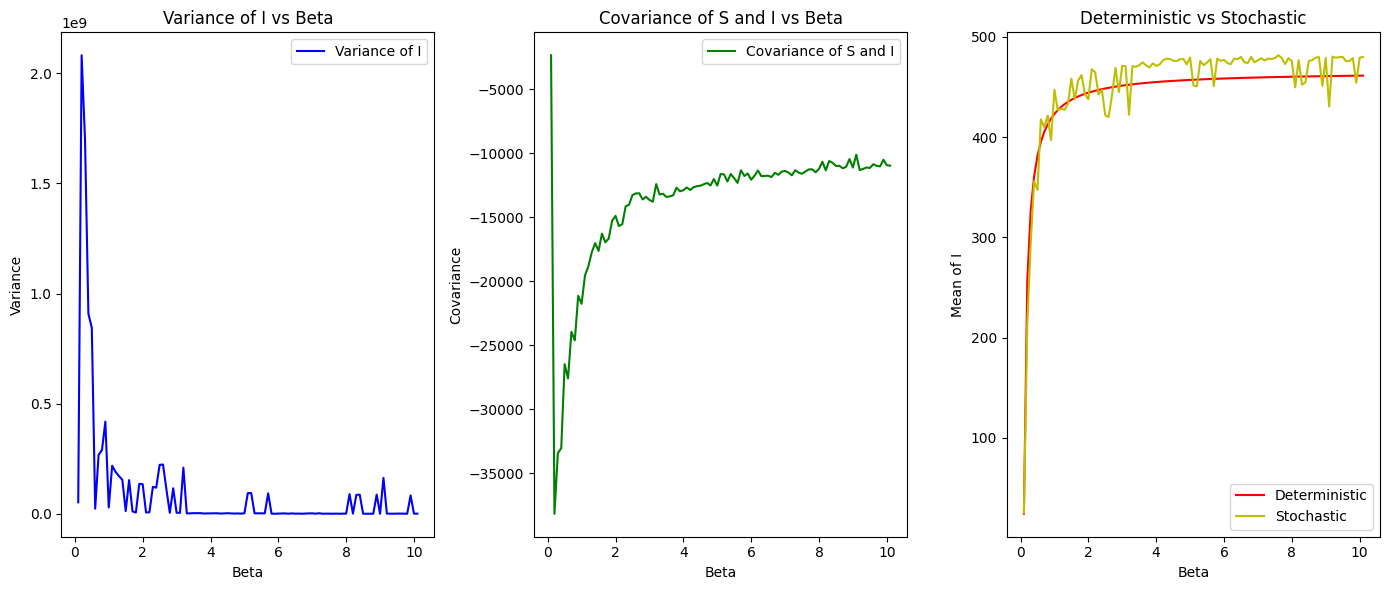

In [7]:
beta = 0
gamma = 1/30
mu = 1/60
params = [beta, gamma, mu]
num_runs = 20
t_max = 100

varI_beta = []
cov_beta = []
beta_list = []
mean_beta_deterministic = []
mean_beta_stochastic = []

while beta < 10:
    beta += 0.1
    params[0] = beta
    beta_list.append(beta)
    S_mean, I_mean, S_var, I_var, cov = multiple_runs(params, num_runs, t_max)
    varI_beta.append(S_var)
    cov_beta.append(cov)
    sol = solve_ivp(sir_model, [0, t_max], initial_conditions, args=(beta, gamma, mu), t_eval=np.linspace(0, t_max, 1000))
    S_d, I_d, R_d = sol.y
    mean_beta_deterministic.append(np.mean(I_d))
    mean_beta_stochastic.append(I_mean)

    

# Create a figure with two subplots (1 row, 3 columns)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))

# First plot: Variance of I vs Beta
ax1.plot(beta_list, varI_beta, label='Variance of I', color='b')
ax1.set_xlabel('Beta')
ax1.set_ylabel('Variance')
ax1.set_title('Variance of I vs Beta')
ax1.legend()

# Second plot: Covariance of S and I vs Beta
ax2.plot(beta_list, cov_beta, label='Covariance of S and I', color='g')
ax2.set_xlabel('Beta')
ax2.set_ylabel('Covariance')
ax2.set_title('Covariance of S and I vs Beta')
ax2.legend()

# Third plot: Comparison of deterministic and stochastic models
ax3.plot(beta_list, mean_beta_deterministic, label='Deterministic', color='r')
ax3.plot(beta_list, mean_beta_stochastic, label='Stochastic', color='y')
ax3.set_xlabel('Beta')
ax3.set_ylabel('Mean of I')
ax3.set_title('Deterministic vs Stochastic')
ax3.legend()

# Adjust layout to prevent overlap
fig.tight_layout()
plt.show()

Now, let's analyse it for different values of $\gamma$, the infection rate.

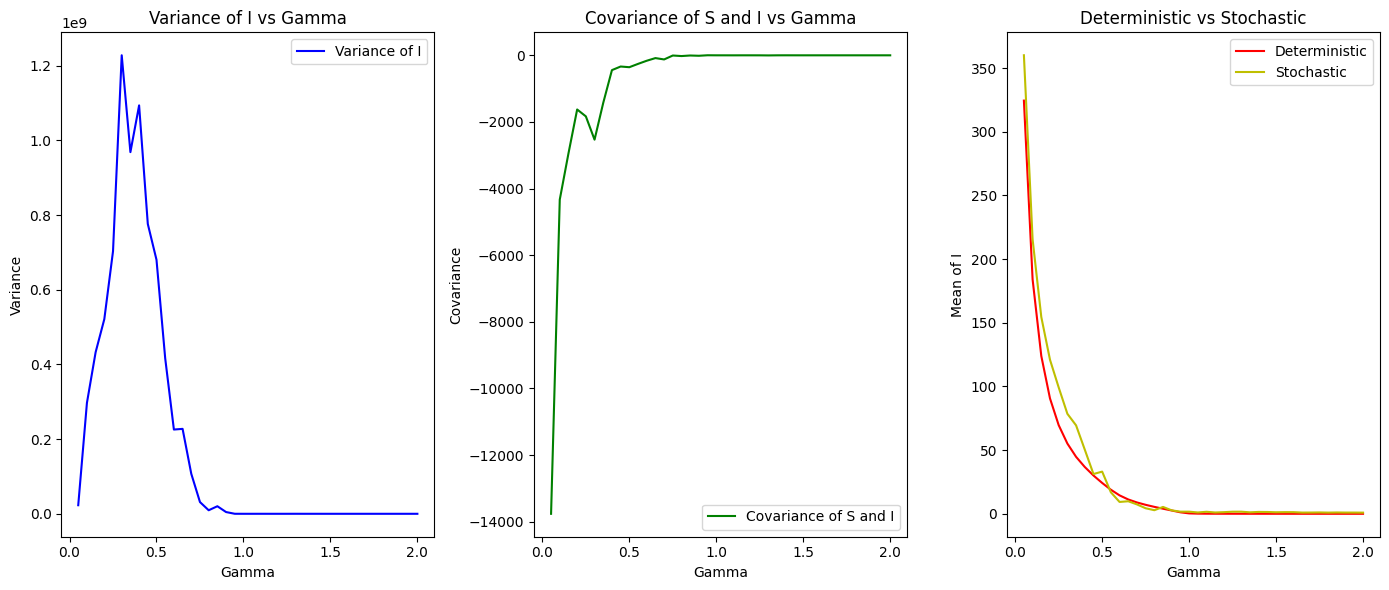

In [8]:
beta = 1
gamma = 0
mu = 1/60
params = [beta, gamma, mu]
num_runs = 20
t_max = 100

varI_gamma = []
cov_gamma = []
gamma_list = []
mean_gamma_deterministic = []
mean_gamma_stochastic = []

while gamma < 2:
    gamma += 0.05
    params[1] = gamma
    gamma_list.append(gamma)
    S_mean, I_mean, S_var, I_var, cov = multiple_runs(params, num_runs, t_max)
    varI_gamma.append(S_var)
    cov_gamma.append(cov)
    sol = solve_ivp(sir_model, [0, t_max], initial_conditions, args=(beta, gamma, mu), t_eval=np.linspace(0, t_max, 1000))
    S_d, I_d, R_d = sol.y
    mean_gamma_deterministic.append(np.mean(I_d))
    mean_gamma_stochastic.append(I_mean)

# Create a figure with two subplots (1 row, 3 columns)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))

# First plot: Variance of I vs Gamma
ax1.plot(gamma_list, varI_gamma, label='Variance of I', color='b')
ax1.set_xlabel('Gamma')
ax1.set_ylabel('Variance')
ax1.set_title('Variance of I vs Gamma')
ax1.legend()

# Second plot: Covariance of S and I vs Gamma
ax2.plot(gamma_list, cov_gamma, label='Covariance of S and I', color='g')
ax2.set_xlabel('Gamma')
ax2.set_ylabel('Covariance')
ax2.set_title('Covariance of S and I vs Gamma')
ax2.legend()

# Third plot: Comparison of deterministic and stochastic models
ax3.plot(gamma_list, mean_gamma_deterministic, label='Deterministic', color='r')
ax3.plot(gamma_list, mean_gamma_stochastic, label='Stochastic', color='y')
ax3.set_xlabel('Gamma')
ax3.set_ylabel('Mean of I')
ax3.set_title('Deterministic vs Stochastic')
ax3.legend()

# Adjust layout to prevent overlap
fig.tight_layout()
plt.show()

For different values of $\mu$, the birth and death rate.

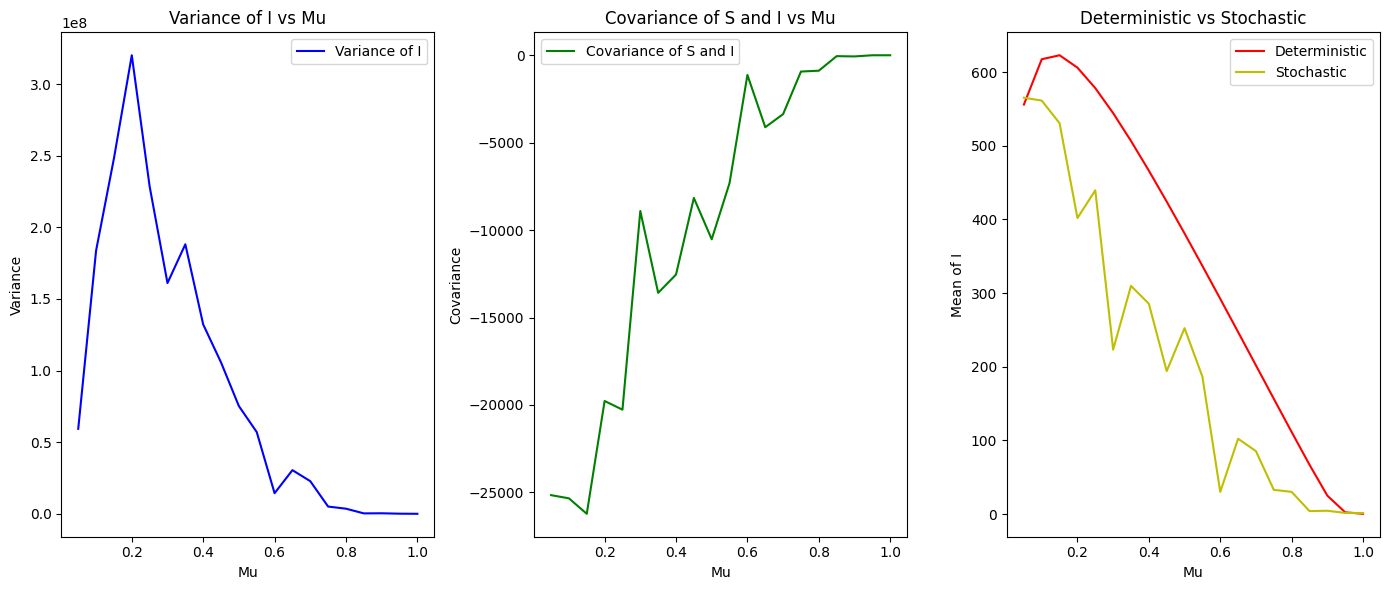

In [9]:
beta = 1
gamma = 1/30
mu = 0
params = [beta, gamma, mu]

num_runs = 20
t_max = 100

varI_mu = []
cov_mu = []
mu_list = []
mean_mu_deterministic = []
mean_mu_stochastic = []

while mu < 1:
    mu += 0.05
    params[2] = mu
    mu_list.append(mu)
    S_mean, I_mean, S_var, I_var, cov = multiple_runs(params, num_runs, t_max)
    varI_mu.append(S_var)
    cov_mu.append(cov)
    sol = solve_ivp(sir_model, [0, t_max], initial_conditions, args=(beta, gamma, mu), t_eval=np.linspace(0, t_max, 1000))
    S_d, I_d, R_d = sol.y
    mean_mu_deterministic.append(np.mean(I_d))
    mean_mu_stochastic.append(I_mean)

# Create a figure with two subplots (1 row, 3 columns)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))

# First plot: Variance of I vs Mu
ax1.plot(mu_list, varI_mu, label='Variance of I', color='b')
ax1.set_xlabel('Mu')
ax1.set_ylabel('Variance')
ax1.set_title('Variance of I vs Mu')
ax1.legend()

# Second plot: Covariance of S and I vs Mu
ax2.plot(mu_list, cov_mu, label='Covariance of S and I', color='g')
ax2.set_xlabel('Mu')
ax2.set_ylabel('Covariance')
ax2.set_title('Covariance of S and I vs Mu')
ax2.legend()

# Third plot: Comparison of deterministic and stochastic models
ax3.plot(mu_list, mean_mu_deterministic, label='Deterministic', color='r')
ax3.plot(mu_list, mean_mu_stochastic, label='Stochastic', color='y')
ax3.set_xlabel('Mu')
ax3.set_ylabel('Mean of I')
ax3.set_title('Deterministic vs Stochastic')
ax3.legend()

# Adjust layout to prevent overlap
fig.tight_layout()
plt.show()
    

For different population sizes, $N$.

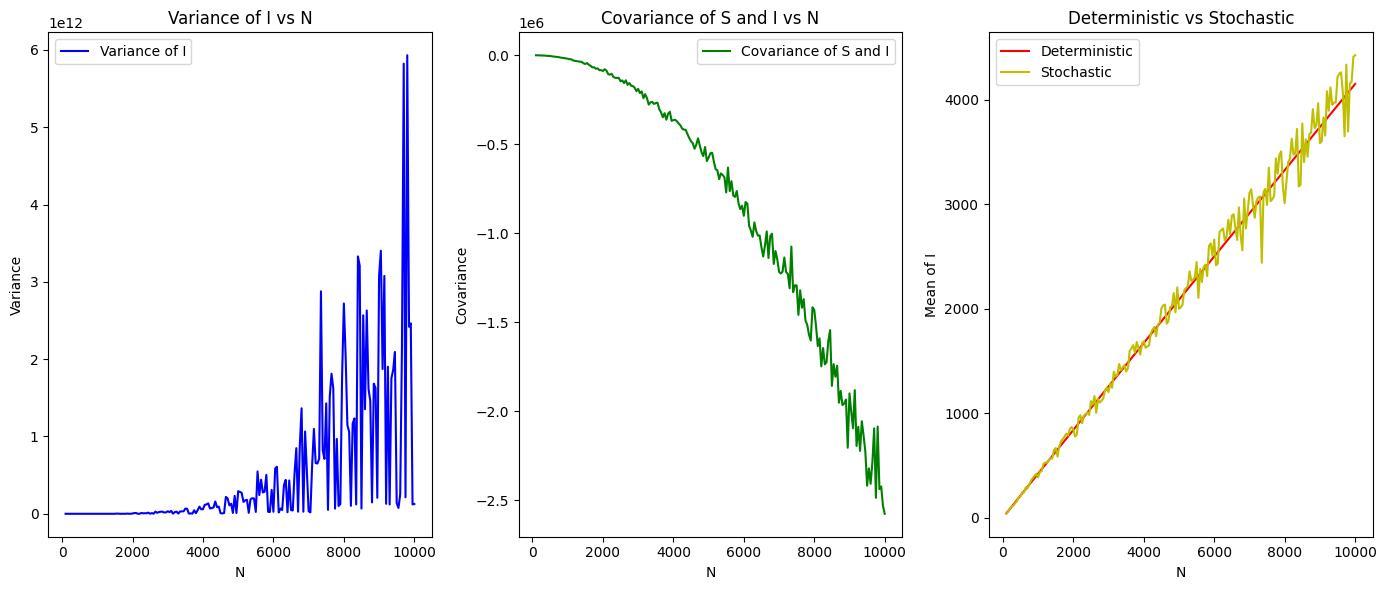

In [10]:
beta = 1
gamma = 1/30
mu = 1/60
params = [beta, gamma, mu]
N = 50

num_runs = 20
t_max = 100

varI_N = []
cov_N = []
N_list = []
mean_N_deterministic = []
mean_N_stochastic = []

while N < 10000:
    N += 50
    S0 = N - 1
    I0 = 1
    R0 = 0
    initial_conditions = [S0, I0, R0]
    N_list.append(N)
    S_mean, I_mean, S_var, I_var, cov = multiple_runs(params, num_runs, t_max)
    varI_N.append(S_var)
    cov_N.append(cov)
    sol = solve_ivp(sir_model, [0, t_max], initial_conditions, args=(beta, gamma, mu), t_eval=np.linspace(0, t_max, 1000))
    S_d, I_d, R_d = sol.y
    mean_N_deterministic.append(np.mean(I_d))
    mean_N_stochastic.append(I_mean)

# Create a figure with two subplots (1 row, 3 columns)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))

# First plot: Variance of I vs N
ax1.plot(N_list, varI_N, label='Variance of I', color='b')
ax1.set_xlabel('N')
ax1.set_ylabel('Variance')
ax1.set_title('Variance of I vs N')
ax1.legend()

# Second plot: Covariance of S and I vs N
ax2.plot(N_list, cov_N, label='Covariance of S and I', color='g')
ax2.set_xlabel('N')
ax2.set_ylabel('Covariance')
ax2.set_title('Covariance of S and I vs N')
ax2.legend()

# Third plot: Comparison of deterministic and stochastic models
ax3.plot(N_list, mean_N_deterministic, label='Deterministic', color='r')
ax3.plot(N_list, mean_N_stochastic, label='Stochastic', color='y')
ax3.set_xlabel('N')
ax3.set_ylabel('Mean of I')
ax3.set_title('Deterministic vs Stochastic')
ax3.legend()

# Adjust layout to prevent overlap
fig.tight_layout()
plt.show()

$R_0 = \frac{\beta}{\gamma + \mu}$

In [11]:
# Initialising the parameters
beta = 1  # infection rate
gamma = 1/5  # recovery rate
mu = 1/60  # birth and death rate
N = 1000  # total population

# Initial conditions
S0 = 999
I0 = 1
R0 = 0
t = 1000 # duration

initial_conditions = [S0, I0, R0]

R0_list = [0.5, 1, 2, 3, 4, 5, 6, 7, 8]
N_list = [100, 250 ,400, 500, 1000, 5000, 10000, 20000]
num_simulations = 10

extinction_dict = {}
for R_0 in R0_list:
    extinction_dict[R_0] = {}
    beta = R_0 * (gamma +mu)
    params = [beta, gamma, mu]
    for N in N_list:
        extinction_dict[R_0][N] = {}    
        extinction_dict[R_0][N] = 0
        S0 = N - 1
        I0 = 1
        R0 = 0
        initial_conditions = [S0, I0, R0]
        for i in range(num_simulations):
            # Running the simulation
            time, result = gillespie(initial_conditions, propensities, stoichiometry, t)
            S, I, R = zip(*result)
            if I[-1] == 0: #check for extinction
                extinction_dict[R_0][N] += 1

# Generate HTML table manually
html_table = '<table style="border-collapse: collapse; width: 100%; font-size: 18px;">'
html_table += '<tr><th colspan="1" style="border: 1px solid black; padding: 10px; text-align: center;">R0 / N</th>'

# Create header row with N values
for N in N_list:
    html_table += f'<th style="border: 1px solid black; padding: 10px; text-align: center;">{N}</th>'
html_table += '</tr>'

# Populate the table rows
for r0 in R0_list:
    html_table += f'<tr><td style="border: 1px solid black; padding: 10px;">{r0}</td>'
    for N in N_list:
        html_table += f'<td style="border: 1px solid black; padding: 10px; text-align: center;">{extinction_dict[r0][N]}</td>'
    html_table += '</tr>'

html_table += '</table>'

# Display the HTML table
from IPython.core.display import display, HTML
display(HTML(html_table))


/var/folders/69/cmszjbhn3tb59lzltkrr4d840000gn/T/ipykernel_75837/2685249663.py:57: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


R0 / N,100,250,400,500,1000,5000,10000,20000
0.5,10,10,10,10,10,10,10,10
1,10,10,10,10,10,10,10,10
2,10,10,10,10,7,6,5,4
3,10,10,10,8,4,2,3,1
4,10,10,8,5,1,5,4,3
5,10,9,7,3,3,1,5,1
6,10,9,3,1,1,1,0,4
7,10,10,2,2,0,2,1,1
8,10,6,4,0,0,3,1,2


In [19]:
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from bokeh.io import output_notebook, show
from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend
import matplotlib.pyplot as plt
import ndlib


# Network Definition
g = nx.erdos_renyi_graph(1000, 0.1)

# Model Selection
model = ep.SIRModel(g)

# Model Configuration
config = mc.Configuration()
config.add_model_parameter('beta', 0.001)
config.add_model_parameter('gamma', 0.01)
config.add_model_parameter("fraction_infected", 0.05)
model.set_initial_status(config)

# Simulation
iterations = model.iteration_bunch(200)
trends = model.build_trends(iterations)

# Visualization
viz = DiffusionTrend(model, trends)
p = viz.plot(width=1000, height=1000)
show(p)

Name: bokeh
Version: 2.3.3
Summary: Interactive plots and applications in the browser from Python
Home-page: http://github.com/bokeh/bokeh
Author: Bokeh Team
Author-email: info@bokeh.org
License: BSD-3-Clause
Location: /opt/anaconda3/lib/python3.12/site-packages
Requires: Jinja2, numpy, packaging, pillow, python-dateutil, PyYAML, tornado, typing-extensions
Required-by: ndlib
Note: you may need to restart the kernel to use updated packages.


100%|██████████| 200/200 [00:00<00:00, 550.10it/s]
